# Clustering Methods


_Summarized by QH_  
_First version: 2022-11-02_  
_Last updated on : 2022-11-02_  

The objective for clustering is to find homogeneous subgroups among the observations.

## K-Means Clustering

K-Means clustering method can partition the datasets into $K$ distinct and non-overlapping segments/clusters. The idea of K-Means is to find a good way to partition the data that can make the _within-cluster variation_ as small as possible.

To define the _within-cluster variation_, the common way is to use Euclidean distance.
* Eclidean distance: $\sqrt{\sum_{j=1}^p (x_{ij} - x_{i'j})^2}$ for observation $i$ and $i'$.

And the _within-cluster variation_ for cluster $k$ is defined as the sum of Pair-wise squared Euclidean distance: 
$$ W(C_k) = \frac{1}{|C_k|} \sum_{i, i' \in C_k} \sum_{j=1}^p (x_{ij} - x_{i'j})^2$$  

where $|C_k|$ denotes the number of observations in the $k$ th cluster.

Our objective is to minimize for the total $K$ clusters' _within-cluster variation_, mathematically:
$$ \text{min}_{c_1, \cdots, c_k} \sum_{k=1}^KW(C_k) $$ 



The algorithm for a dataset with number of observations being $n$ and number of features being $p$:
1. Randomly initial $K$ _centroid_.
2. Iterate until the cluster assignments stop changing:  
    a. Assign each observation to the closest cluster centroid. Closest is measured using Euclidean distance.  
    b. For each of the $K$ clusters, compute the cluster _centroid_. The $k$th cluster centroid is the vector of $p$ features, for each feature value being the average of the observations' feature value in that cluster.

Notes:
* The algorithm gurantees to decrease the _within-cluster variation_ since each steps is to find the observation that's closest to each other. And mathematically it is because:
$$ \frac{1}{|C_k|} \sum_{i, i' \in C_k} \sum_{j=1}^p (x_{ij} - x_{i'j})^2 = 2\sum_{i \in C_k} \sum_{j=1}^p (x_{ij} - \bar{x}_{kj})^2$$ 
* It may get into local optimum given different initialization.

Advantages:
* Easy and straightforward to implement and understand

Drawbacks:
* Need to pre-specify number of clusters $K$. 
    * We can use __elbow method__ using sum of _within-cluster variation_ or _average silhoutte score_ to determine the $K$.
    * Use business knowledge together with mathematical methods to determine.
* Need to initialize the $K$ centroids which may results in different local optimum. 
    * Suggest to run multiple times with different initialization and choose the one that minimize the sum of _within-cluster variation_.
* K-Means uses the spherical or elliptical metric to group data. That means it is best suited for data that is clustered in the sphere shape. If the clusters are non-spherical or none-convex(e.g. concentrated circles like below), then K-Means will perform not as desired.

<img src="circles.png" alt="circle_png" width="250"/>

### Elbow method

To determine the optimal number of clusters, _elbow method_ is typically useful. It usally run multiple times with different $K$ (number of clusters) and record the intra-cluster distortion measure and plot them and pick the number of clusters that on the elbow point of the curve as the optimal one. The following is an example from `yellobrick` library.


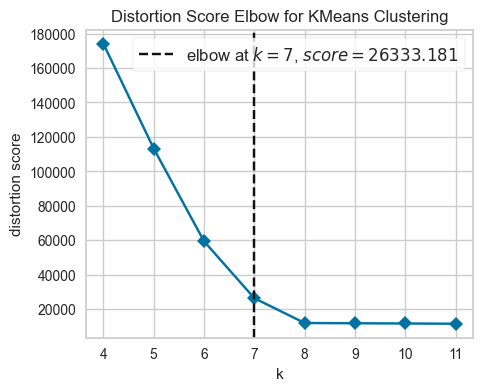

In [20]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt

# Generate synthetic dataset with 8 random clusters
X, y = make_blobs(n_samples=1000, n_features=12, centers=8, random_state=42)

# Instantiate the clustering model and visualizer
model = KMeans()
plt.figure(figsize=(5, 4))
# distortion: Sum of squared distance from each point to its assigned center
visualizer = KElbowVisualizer(model, k=(4,12), timings=False, metric='distortion', distance_metric='euclidean')

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure
plt.show()

#### Metrics
* Distortion Score (or Inertia from `KMeans` output): The sum of all squared distance from each point to its assigned center. Normally the distance is defined as Euclidean distance. The smaller the better.
* Silhoutte Score: 
    * Silhoutte coeffient ($s_i$) for a sample $i$ $\frac{b_i - a_i}{\max(a_i, b_i)}$
    where $$b_i = \min_{J \neq I} \frac{1}{|C_J|} \sum_{j \in C_J} d(i, j)$$ is minimum of average inter-cluster distance and $$a_i = \frac{1}{|C_I| - 1} \sum_{j \in C_I, i \neq j} d(i, j)$$ is average intra-cluster distance
    * $-1 \le s_i \le 1$. When $a_i \ll b_i$, $s_i$ is close to 1 which means the points within a cluster is tight compared to other clusters.

## Agglomerative (Bottom-up) Hierarchical Clustering

### Understanding a dendrogram
* At the bottom of the tree represents individual observations (leafs). When we move up the tree, leaves begin to fuse into branches because they are similar to each other.
* The height of the fusion as measure on the vertical axis represents the dis-similarity of two clusters.
* The closeness in the horizontal axis does not represent the similarity.

### Main Idea and Dissimilarity

The main idea for the agglomerative hierarchical clustering is that 
* Starting out at the bottom of the dendrogram, each of the $n$ observations is treated as its own cluster. 
* The two clusters that are most similar to each other are then fused so that there now are $n−1$ clusters. 
* Next the two clusters that are most similar to each other are fused again, so that there now are $n − 2$ clusters. The algorithm proceeds in this fashion until all of the observations belong to one single cluster.

From this idea we need a measurement for similarity or dissimilarity. For two observations we can use Euclidean Distance, how about the dissimlarity between two clusters? We can use _linkage_.
There are four types of _linkage_: _complete_, _average_, _single_, and _centroid_.

|Linkage|Description|
|----|:--|
|Complete|Maximal intercluster dissimlarity. Compute all pairwise dissimlarities between observations in cluster A and the observations in cluster B and record the _largest_ of these dissimalrities|
|Single|Minimal intercluster dissimilarity. Compute all pariwise dissimilarities between observations in cluster A and the observations in cluster B and record the _smallest_ of these dissimilarities. Single linkage can result in extended, trailing clusters in which single observations are fused one-at-a-time.|
|Average|Mean intercluster dissimilarity. Compute all pariwise dissimilarities between observations in cluster A and the observations in cluster B and record the _average_ of these dissimilarities.|
|Centroid|Dissimilarity between the centroid for clusters A and the centroid for cluster B. Centroid linkage can result in undesirable _inversions_. An _inversion_ occur when two clusters are fused at a height below either of the individual clusters in the dendrogram.|

 ### Hierarchical Clustering Algorithm
 1. Treat each of the $n$ observation as its own cluster and record the dissimilarity measure (e.g. Euclidian distance) for all pairwise dissimilarity.
 2. For $i = n, n-1, \cdots, 2$:
    a. Examine all pairwise inter-cluster dissimilarities among the $i$ clusters and identify the pair of clusters that are most similar. Fuse these two clusters. The dissimilarity between these two clusters indicates the height in the dendrogram where the fusion takes place.  
    b. Compute the new pairwise inter-cluster dissimilarities among the $i-1$ remaining clusters.

Notes:
* Compared to K-Means, Hierarchical Clustering does not need to pre-specify number of clusters.
* Hierarchical clustering sets the assumption that clusters are netted. That means, if the clusters are not nested, using hierarchical clustering may yield wose results than K-Means clustering for a given number of clusters.
* Choice of dissimilarity measures:
    * Correlation-based dissimilarity measure is preferred to be used when the focus is on the shape of observation profiles instead of their magnitude. 
        * e.g. Using shoppers' historical shopping data to do segmentation. If the goal is to group them by their shopping preference (e.g., buying computers and office suplies together) then correlation-based dissimilarity measure is more appropriate.

Practical issues when doing clustering:
* Should the observations or features first be standardized some way? (e.g. scaled to standard deviation)
* Hierarchical clustering:
    * What dissimilarity measure should be used?
    * What type of linkage should be used?
    * Where should we cut the dendrogram in order to obtain clusters?
* K-Means Clustering:
    * How many clusters should we look for in the data?

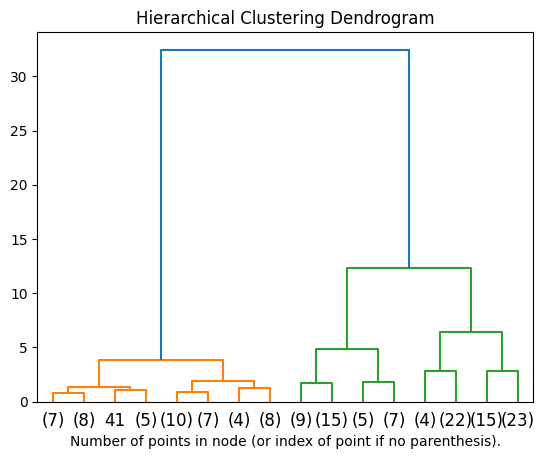

In [1]:
# This example is from scikit-learn 1.1.3 example:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


iris = load_iris()
X = iris.data

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

## Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

DBSCAN comes to address the disadvantages of K-Means which assumes clusters are convex shaped. The core concept is based on the determining the neighbors of core samples which are in the area of high density.

* Terminologies:
    * _core sample_: A sample in the dataset such that there exist `min_samples` other samples within a distance of `eps`. Otherwise, the sample is _non-core sample_. Where `min_samples` and `eps` are user-defined.
    * _neighbors_: Samples that are within the distance of `eps` of one sample. These samples are called the _neighbors_ of that one sample.

The algorithm:
1. Pre-determine the `min_samples` and `eps`. Scan through all the samples in the dataset and find _core samples_ and _non-core samples_.
2. Repeat the following process until no _core samples_ left out without being in a cluster:  
    * Randomly pick a _core sample_ that not has been grouped to a cluster and assign it in a new cluster. The _core samples_ that are within `eps` distance of this _core sample_ is grouped in the sample cluster. We then use these neighbor _core samples_ to find other neighbor _core samples_ using the same `eps` and group them into the same cluster. Repeat until no more _core samples_ can be added to this cluster.  
    * Add the _non-core sample_ neighbors of the _core samples_ in this cluster to this cluster.  
3. The _non-core samples_ that are not belong to any of the clusters are outliers.

Note:
* DBSCAN is sequential so the _non-core samples_ that on the fringe of both clusters will be categorized into the cluster that has been created first.
<img src="dbscan.gif" alt="dbscan-gif" width="250"/>

# References
1. Introduction to Statistical Learning
2. Machine Learning Course by Andrew Ng on Coursera
3. Scikit-Learn Online Clustering documents
4. StatQuest with Josh Starmer Youtube Channel
5. DBSCAN gif is from https://ml-explained.com/blog/dbscan-explained